<h1>Máster de Ciencia de Datos e Ingenieria de computadores.</h1>
<h2> Visión por Computador </h2>
<h3> <strong> Autores: </strong>Brian Sena Simons y Miguel García López </h3>

# Inúndación Texas

/home/briansenas/Documents/landsat-remote-sensing/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


dtype: uint8, shape: (1024, 1024), min: 0, max: 255


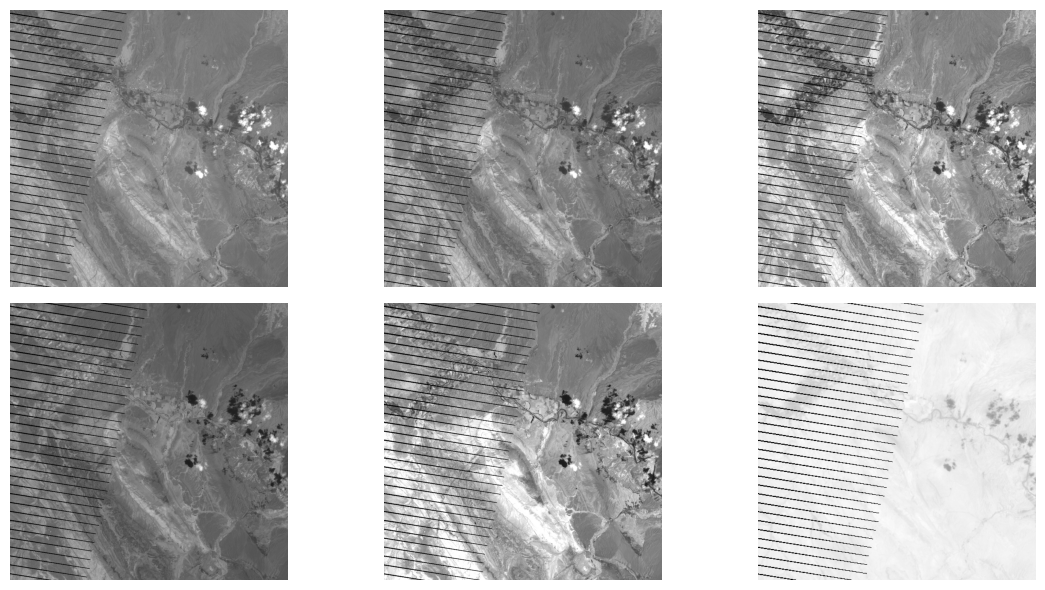

In [218]:
import os 
import glob
import cv2
import rasterio
import matplotlib.pyplot as plt
import numpy as np

texas_path = os.path.join("Lansat", "texas")
texas_imgs_files = sorted(glob.glob(os.path.join(texas_path, "agosto_banda*.tif")))
texas_imgs = list(map(lambda x: rasterio.open(x).read(1).astype(np.uint8), texas_imgs_files))
img = texas_imgs[0]
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')

def plot_array(rows: int, cols: int, data: list, cmap='gray', **kwargs):
  """Plots an array given the rows and cols"""
  fig, ax = plt.subplots(rows, cols, **kwargs)
  ax = ax.ravel()
  for i, img in enumerate(data[:rows*cols]):
      ax[i].imshow(img, cmap)
  return fig, ax

fig, ax = plot_array(2, 3, texas_imgs, tight_layout=True, figsize=(12,6))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

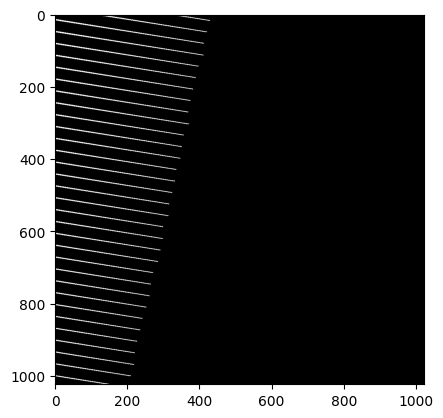

In [175]:
# Filter the black lines
black_artifact_thresh = 10
mask = (texas_imgs[0] < black_artifact_thresh).astype(np.uint8)
plt.imshow(mask, 'gray')
plt.show()

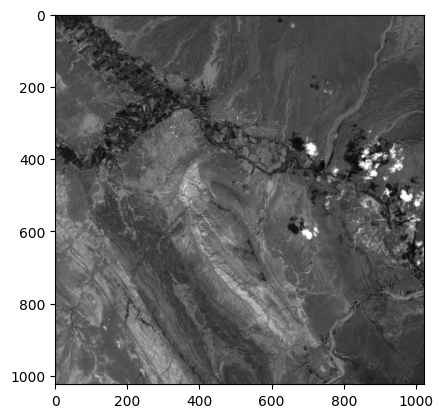

In [176]:
# Review inpainting
rec = cv2.inpaint(texas_imgs[0], mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
plt.imshow(rec, 'gray')
plt.show()

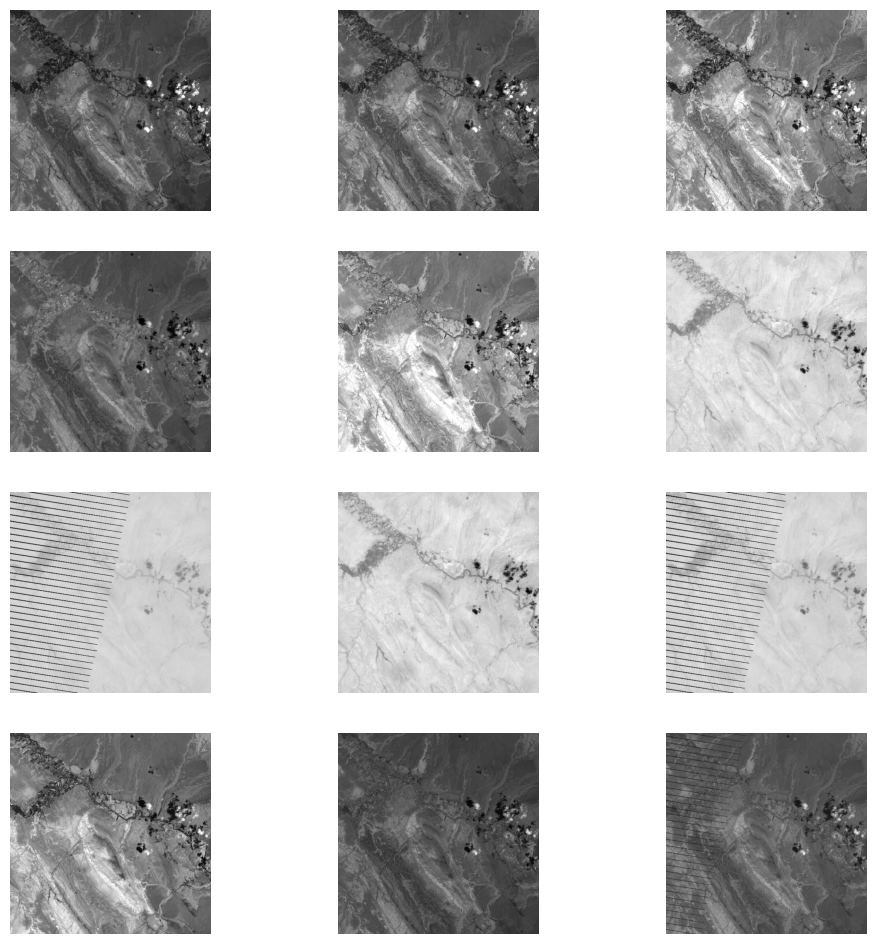

In [177]:
# Set threshold for detecting black pixels
black_artifact_thresh = 10
# Create image masks
texas_imgs_masks = list(map(lambda x: (x < black_artifact_thresh).astype(np.uint8), texas_imgs))
# Interpolate over the black pixels masks
texas_imgs_clean = list(map(lambda img, mask: cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA), texas_imgs, texas_imgs_masks))
# Plot the results
fig, ax = plot_array(4, 3, texas_imgs_clean, figsize=(12,12))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

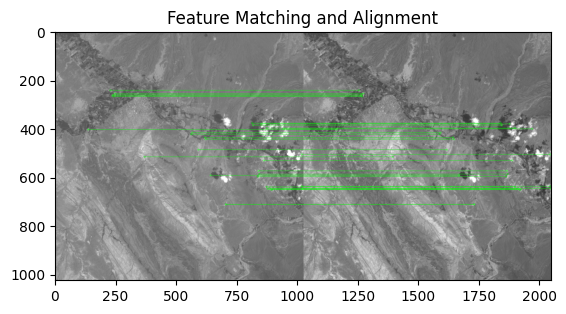

(1024, 1024)


In [243]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def align_band(img1: np.ndarray, img2: np.ndarray, threshold: float = 0.7, visualize: bool = False) -> np.ndarray:
  """
  Aligns img2 to img1 using SIFT feature matching and homography transformation.
  Code adapted from: https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

  Parameters:
  img1 (np.ndarray): Reference image (3-channel RGB).
  img2 (np.ndarray): Image to be aligned (3-channel RGB).
  threshold (float): Lowe's ratio test threshold for filtering good matches.
  visualize (bool): If True, displays the matching keypoints and transformation.

  Returns:
  np.ndarray: Aligned version of img2 (3-channel RGB).
  """
  MIN_MATCH_COUNT = 10
  
  # Initialize SIFT detector
  sift = cv2.SIFT_create()
  
  # Detect keypoints and compute descriptors
  keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
  
  # FLANN-based matcher parameters
  index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE = 1
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  
  # Find matches using KNN
  matches = flann.knnMatch(descriptors1, descriptors2, k=2)
  
  # Apply Lowe's ratio test
  good_matches = [m for m, n in matches if m.distance < threshold * n.distance]
  
  if len(good_matches) >= MIN_MATCH_COUNT:
    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute homography matrix
    homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warp img2 to align with img1
    height, width = img1.shape
    aligned_img = cv2.warpPerspective(img2, homography_matrix, (width, height))
    
    if visualize:
      matches_mask = mask.ravel().tolist()
      draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask, flags=2)
      img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, **draw_params)
      plt.imshow(img_matches, cmap='gray')
      plt.title("Feature Matching and Alignment")
      plt.show()
    
    return aligned_img
  else:
    print(f"Not enough matches found: {len(good_matches)}/{MIN_MATCH_COUNT}")
    return img2  # Return original image if alignment fails

aligned = align_band(texas_imgs_clean[0], texas_imgs_clean[1], threshold=0.1, visualize=True,)
print(aligned.shape)

In [253]:
green_band = texas_imgs_clean[np.strings.endswith(texas_imgs_files, 'banda2.tif').nonzero()[0][0]]
nir_band = texas_imgs_clean[np.strings.endswith(texas_imgs_files, 'banda4.tif').nonzero()[0][0]]

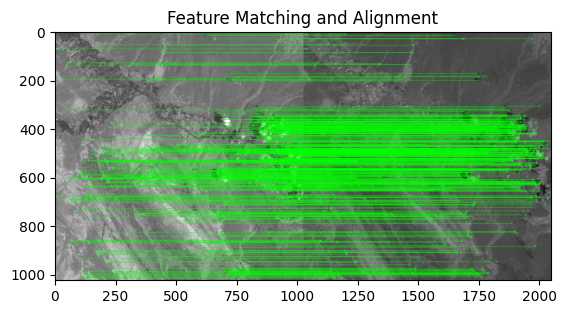

In [254]:
aligned_nir= align_band(green_band, nir_band, visualize=True)

In [255]:
# Compute NDWI using OpenCV
green_band = green_band.astype(np.float32)
aligned_nir = aligned_nir.astype(np.float32)
ndwi = cv2.divide(cv2.subtract(green_band, aligned_nir), cv2.add(green_band, aligned_nir + 1e-10))
# Normalize to 0-255 for visualization
ndwi_vis = cv2.normalize(ndwi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

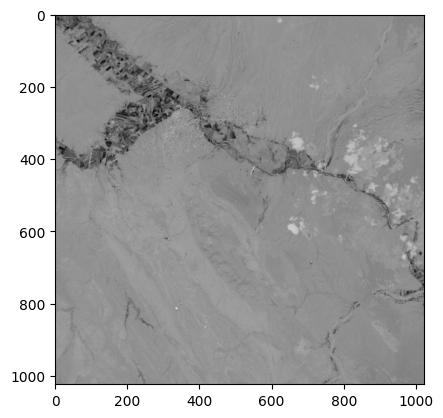

In [256]:
plt.imshow(ndwi_vis, 'gray')
plt.show()

In [257]:
import numpy as np
# Umbral de NDWI 
# How to interpret NDWI: https://eos.com/make-an-analysis/ndwi/
umbral = 0.2  # NDWI > 0 indica agua
# Crear una máscara binaria donde NDWI > umbral (agua = 1, no agua = 0)
mascara_agua = np.where(ndwi > umbral, 1, 0)
# Calcular el número de píxeles de agua
num_pixeles_agua = np.sum(mascara_agua)
# Área por píxel en km² (900 m² = 0.0009 km²)
# https://es.wikipedia.org/wiki/Landsat_7 15 metros por píxel
area_por_pixel = 1.5e-5 # km²
# Calcular el área total de inundación en km²
area_inundacion_km2 = num_pixeles_agua * area_por_pixel
print(f"Área estimada de la inundación en Texas: {area_inundacion_km2:.2f} km²")

Área estimada de la inundación en Texas: 6.77 km²


# Arizona

# Adra

# Bibliografía

1. [Normalized Difference Water Index](https://en.wikipedia.org/wiki/Normalized_difference_water_index)

# Apéndice

In [258]:
# Align all images: 
reference = texas_imgs_clean[0]
texas_imgs_clean_aligned = [reference]
for img in texas_imgs_clean[1:]:
  aligned = align_band(reference, img, threshold=0.85, visualize=False)
  texas_imgs_clean_aligned.append(aligned)

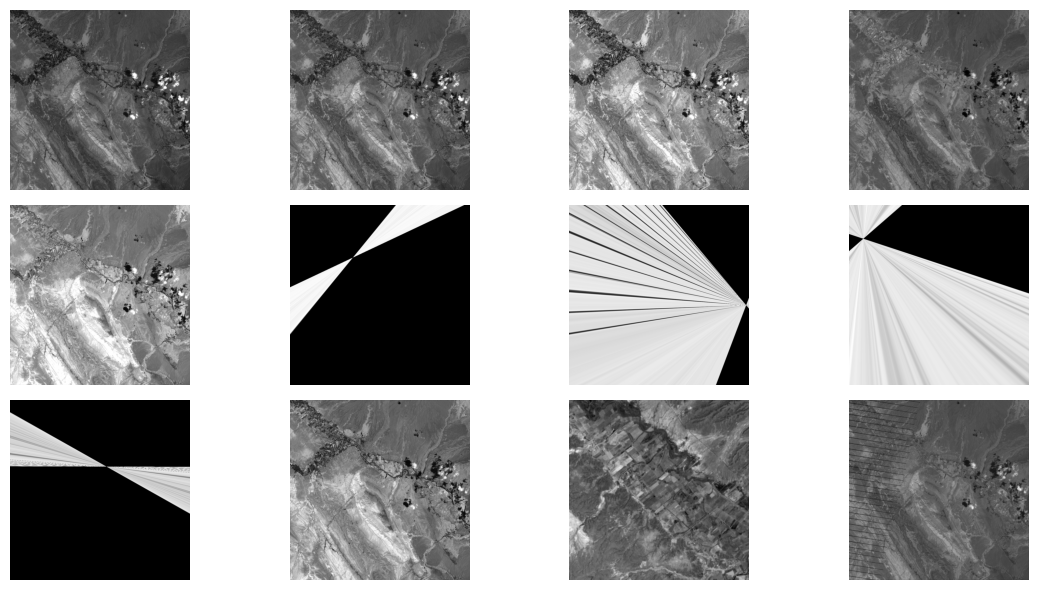

In [259]:
fig, ax = plot_array(3, 4, texas_imgs_clean_aligned, tight_layout=True, figsize=(12, 6))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

Se observa que SIFT no parece ser lo más adecuado para hacer homografías entre las imágenes de las bandas 6 con respecto a la imagen 1.